# ARCH

When constructing ARMA and ARIMA models, one of the underlying assumptions was homoskedasticity, i.e. homogeneity of the time-series variance over time. In real world time-series, the assumption of a constant conditional variance is frequently violated. 

Models such as the autoregressive conditionally heteroskedastic or ARCH model, first introduced by Engle (1982), were developed to model changes in volatility. These models were later extended to generalized ARCH, or GARCH models by Bollerslev (1986).


Plotting the daily returns of any equity readily shows volatility clustering, with large upside and downside movements tending to be temporally correlated. The plot below shows the daily stock returns of SPY as compared with a truly homoskedastic process.

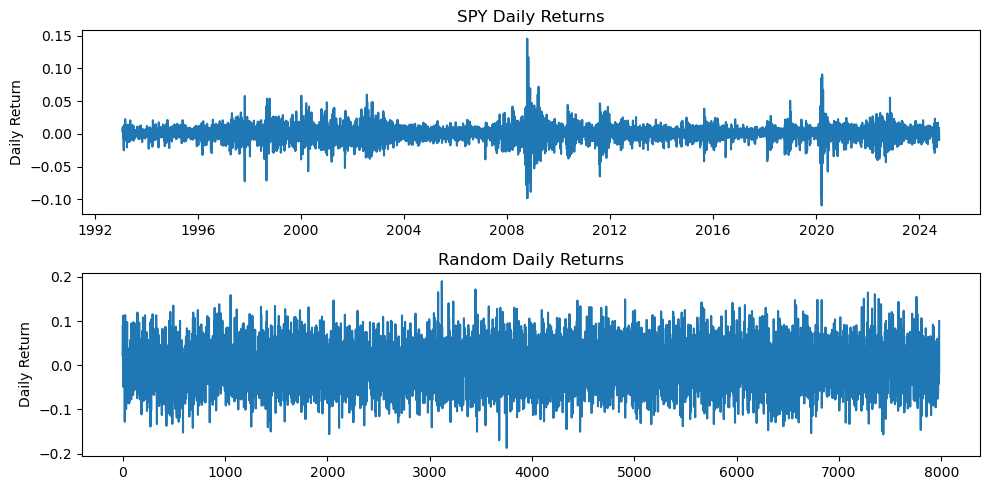

In [8]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch the data
stock = yf.Ticker("SPY")
data = stock.history(period="max")

# Calculate the daily returns
data['daily_return'] = data['Close'].pct_change()


# Include Random Noise as an example that is truly homoskedastic
import numpy as np
np.random.seed(0)
random_returns = np.random.normal(0, 0.05, len(data))

# Plot SPY and Random Returns on a grid with aapl at top and random at bottom
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data['daily_return'])
plt.title('SPY Daily Returns')
plt.ylabel('Daily Return')
plt.subplot(2, 1, 2)
plt.plot(random_returns)
plt.title('Random Daily Returns')
plt.ylabel('Daily Return')
plt.tight_layout()


Let $\epsilon_t$ denote the error terms (return residuals, with respect to a mean process). These $\epsilon_t$ are split into a stochastic piece $z_t$ (otherwise known as a white-noise process) and a time-dependent standard deviation $\sigma_t$ characterizing the typical size of the terms so that
\begin{equation}
	\epsilon_t = \sigma_t z_t.
\end{equation}

An ARCH($q$) process is then defined by modelling the series $\sigma_t$ by
\begin{equation}
\sigma_t^2 = \alpha_0 + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2,
\end{equation}
where $\alpha_0 > 0$ and $\alpha_i \geq 0$, $i > 0$.

# ARCH(1)

Let us consider an ARCH model of order 1 to better understand how this models volatility. With $q=1$, we have
\begin{equation}
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2,
\end{equation}
where $\alpha_0$ and $\alpha_1$ are parameters of the model. Rearranging for $\epsilon_t$ in terms of $z_t$ and the model parameters, we find
\begin{equation}
\epsilon_t = z_t \sqrt{\alpha_0 + \alpha_1 \epsilon_{t-1}^2}.
\end{equation}

Looking at the variance of $\epsilon_t$, we find
\begin{align}
\textrm{Var}(\epsilon_t)  &= \mathbb{E}[\epsilon_t^2] - (\mathbb{E}[\epsilon_t])^2, \notag\\
													&= \mathbb{E}[\epsilon_t^2], \notag\\
													&= \mathbb{E}[z_t^2]\mathbb{E}[\alpha_0 + \alpha_1 \epsilon_{t-1}^2], \notag\\
													&= \mathbb{E}[\alpha_0 + \alpha_1 \epsilon_{t-1}^2], \notag\\
													&= \alpha_0 + \alpha_1 \textrm{Var}(\epsilon_{t-1}).
\end{align}
This tells us that the variance of an ARCH(1) process follows an AR(1) process, i.e. the variance is autoregressed on the variance of the prior elements of the series.

# GARCH

Since an ARCH(p) process can be thought of as applying an AR(p) model to the variance of the series, an obvious question to consider is why not also apply an ARMA($p,q$) model to model the variance? This is the motivation for the Generalised ARCH (GARCH) model.

For a time-series given at each timestep $t$ by
\begin{equation}
	\epsilon_t = \sigma_t z_t,
\end{equation}
in a GARCH model, the variance $\sigma_t^2$ is described by
\begin{equation}
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^q\beta_j \sigma^2_{t-j},
\end{equation}
where $\alpha_i$ and $\beta_j$ are parameters of the model, $p$ is the order of the AR process used to model the variance, and $q$ is the order of the MA part of the model. Thus GARCH is to ARCH what ARMA is to AR.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Percentage change (%)')

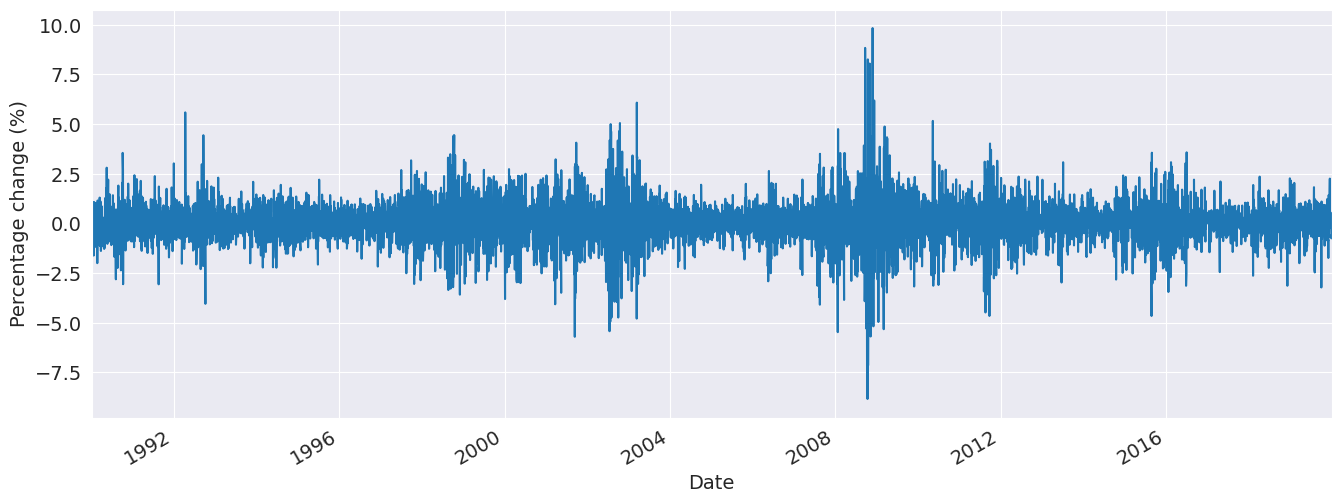

In [12]:
import yfinance as yf
import datetime

start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2020, 1, 1)
data = yf.download('^FTSE', start=start, end=end)
returns = 100*data['Adj Close'].pct_change().dropna()

ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
ax.set_ylabel('Percentage change (%)')

We use the PACF to determine which order GARCH process to use.

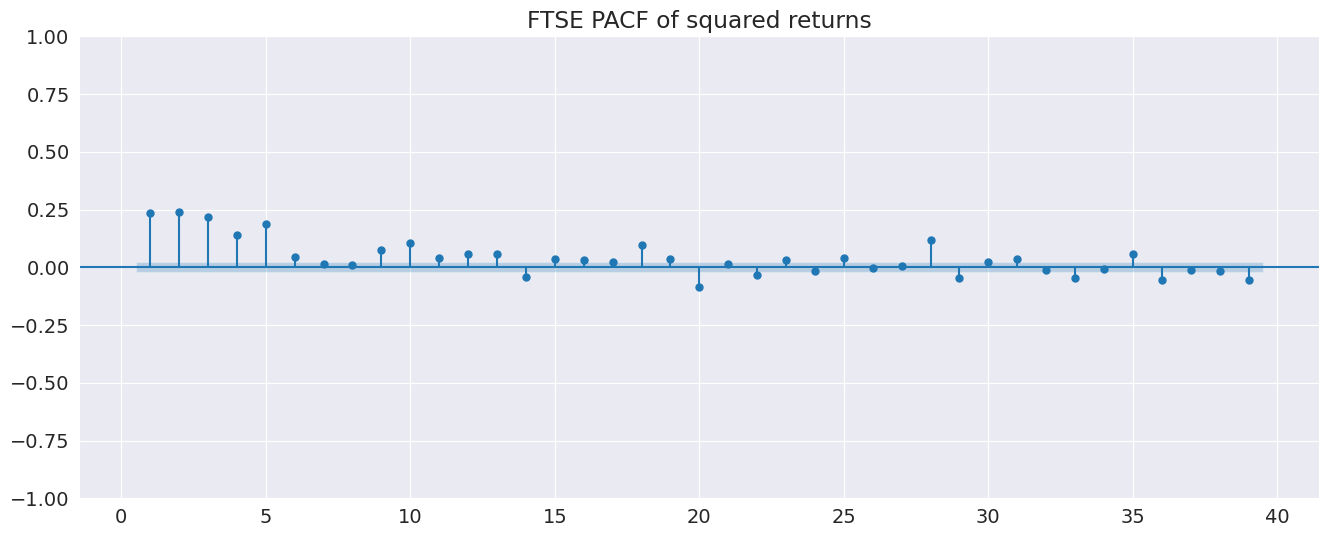

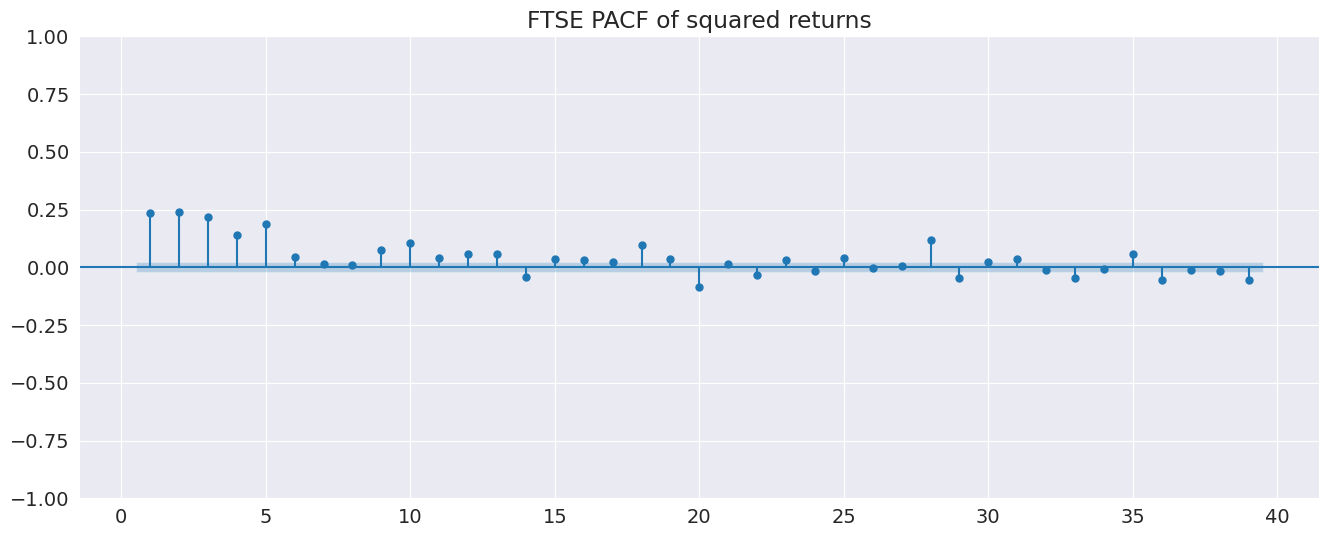

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(returns**2,  title='FTSE PACF of squared returns', zero=False)

We see strong autocorrelation up to lag 5.

In [14]:
from arch import arch_model

model = arch_model(
    returns, 
    vol='GARCH', 
    p=4, 
    o=0, 
    q=4, 
    dist='Normal'
)
model_fit = model.fit(disp='off')

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10074.3
Distribution:                  Normal   AIC:                           20168.7
Method:            Maximum Likelihood   BIC:                           20238.0
                                        No. Observations:                 7578
Date:                Tue, Oct 08 2024   Df Residuals:                     7577
Time:                        08:13:49   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0396  9.357e-03      4.237  2.262e-05 [2.131e-02,5.799e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0585  1.425e-02      4.102  4.091e-05 [3.053e-02,8.639e-02]
alpha[1]       0.0792  1.479e-02      5.353  8.629e-08   [5.020e-02,  0.108]
alpha[2]       0.0900  1.702e-02      5.287  1.243e-07   [5.662e-02,  0.123]
alpha[3]       0.0897  1.864e-02      4.815  1.476e-06   [5.320e-02,  0.126]
alpha[4]       0.0663  1.576e-02      4.206  2.597e-05 [3.540e-02,9.719e-02]
beta[1]        0.0000      0.183      0.000      1.000     [ -0.358,  0.358]
beta[2]    4.1147e-09      0.155  2.657e-08      1.000     [ -0.304,  0.304]
beta[3]    4.0830e-09      0.159  2.576e-08      1.000     [ -0.311,  0.311]
beta[4]        0.6221      0.130      4.784  1.719e-06     [  0.367,  0.877]
============================================================================

Covariance estimator: robust
"""

Above, we see that the beta coefficients have high p-values, implying they are poor predictors in the model. For this reason we will try GARCH(4,0) next, which is equivalent to ARCH(4).

In [59]:
from arch import arch_model

model = arch_model(returns, vol='GARCH', p=4, o=0, q=0, dist='normal')
model_fit = model.fit(disp='off')

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10317.2
Distribution:                  Normal   AIC:                           20646.5
Method:            Maximum Likelihood   BIC:                           20688.1
                                        No. Observations:                 7578
Date:                Fri, Jul 12 2024   Df Residuals:                     7577
Time:                        16:41:04   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0432  9.667e-03      4.466  7.968e-06 [2.423e-02,6.212e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3652  1.841e-02     19.840  1.340e-87 [  0.329,  0.401]
alpha[1]       0.1539  2.390e-02      6.440  1.192e-10 [  0.107,  0.201]
alpha[2]       0.1891  1.982e-02      9.537  1.464e-21 [  0.150,  0.228]
alpha[3]       0.2115  2.239e-02      9.447  3.492e-21 [  0.168,  0.255]
alpha[4]       0.1482  1.765e-02      8.397  4.594e-17 [  0.114,  0.183]
========================================================================

Covariance estimator: robust
"""

The above model seems to have fit successfully, with all alpha parameters having p-values well below the 5% confidence level.

## Rolling Forecast

Below, over a 1 year time period, we train a new garch model for each day and use it to make a prediction of the volatility for the next day.

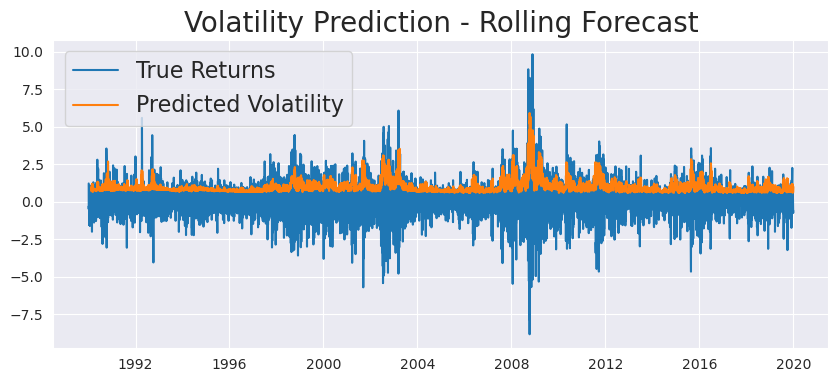

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import concurrent.futures


def fit_and_forecast(i, returns):
    # Use data up to the current point
    train = returns[:i]
    model = arch_model(train, p=5, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    return np.sqrt(pred.variance.values[-1, :][0])


# Adjust to use the entire range of data
data_length = len(returns)

# Use ProcessPoolExecutor to parallelize the loop
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Adjust the range to cover the entire dataset
    results = [executor.submit(fit_and_forecast, i, returns) for i in range(30, data_length + 1)]
    rolling_predictions = [result.result() for result in concurrent.futures.as_completed(results)]

# Adjust the index for rolling_predictions to match the returns dataset
rolling_predictions = pd.Series(rolling_predictions, index=returns[30-1:].index)

plt.figure(figsize=(10, 4))
true, = plt.plot(returns)
preds, = plt.plot(rolling_predictions)
plt.rc("font", size=10)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

Above we see the volatility prediction from GARCH overlaid above the percentage return. This is only to make the point that the volatility predictions follow the periods we would intuitively recognize as being periods of high volatility.

We can now use the model to make a volatility prediction for the future

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

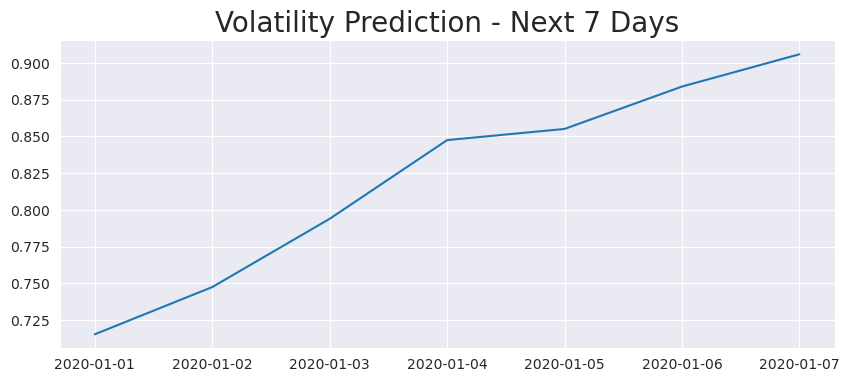

In [58]:
from datetime import timedelta

train = returns
model = arch_model(train, p=5, q=0)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1, 8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1, :]), index=future_dates)

plt.figure(figsize=(10, 4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)